In [2]:
import import_ipynb
import wheat_dataset
from wheat_dataset import WheatDataset
from wheat_dataset import nostdout
from wheat_dataset import extract_coco_annotations

from detection_utils import collate_fn
from detection_engine import train_one_epoch, evaluate, evaluate_loss
from utils_dataset import get_transform_albumentation, get_transform_imgaug_img, get_transform_torch_img

%matplotlib inline
import matplotlib.pyplot as plt

import os
import copy
import random
import traceback
import numpy as np
from PIL import Image
from datetime import date

import pandas as pd
from pandas.io.formats.style import Styler

import torch
import torchvision
from torchvision.transforms import transforms as T
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

import imgaug.augmenters as iaa

In [2]:
root = "/home/emj6571/dataset_aehren"
model_path = "/home/emj6571/model"

mean = torch.Tensor([0.2133, 0.2256, 0.1655])
std = torch.Tensor([0.1672, 0.1721, 0.1526])

In [3]:
# set seed
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("Seed set!")

seed_torch()

Seed set!


In [4]:
# sets display for pandas dataframe
def set_pandas_display_options():
    display = pd.options.display
    display.max_columns = 10
    display.max_rows = 10
    display.max_colwidth = 199
    display.width = 1000
set_pandas_display_options()

# Helper Function to generate Mask-RCNN

In [5]:
# creates mask-rcnn
def get_model_maskrcnn(num_classes):
    BOX_DETECTIONS_PER_IMG = 200
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT", box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    # change normalization (transform layer)
    grcnn = torchvision.models.detection.transform.GeneralizedRCNNTransform(min_size=800, max_size=1333, image_mean=mean, image_std=std)
    model.transform = grcnn
    
    return model

# Training

In [6]:
# inspired by: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
def main():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

    num_classes = 2
    dataset = WheatDataset(root, get_transform_albumentation(train=True), plot=False)
    dataset_test = WheatDataset(root, get_transform_albumentation(train=False), plot=False)

    # split dataset in train, validation and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset_train = torch.utils.data.Subset(dataset, indices[:362])
    dataset_validation = torch.utils.data.Subset(dataset_test, indices[362:439])
    dataset_testing = torch.utils.data.Subset(dataset_test, indices[-77:])

    # define training, validation and test data loaders
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=4, shuffle=True, num_workers=0,
        collate_fn=collate_fn)

    data_loader_validation = torch.utils.data.DataLoader(
        dataset_validation, batch_size=2, shuffle=False, num_workers=0,
        collate_fn=collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_testing, batch_size=2, shuffle=False, num_workers=0,
        collate_fn=collate_fn)

    # get the model using our helper function
    model = get_model_maskrcnn(num_classes)
    model.to(device)

    # optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    num_epochs = 1

    augmentet_data_counter = 0
    logger_full, logger_sum, val_losses = [], [], []
    for epoch in range(1, num_epochs+1):
        # train for one epoch, printing every 10 iterations
        batch_logger_full, batch_logger_sum, augmentet_data_train = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
        logger_full.append(batch_logger_full)
        logger_sum.append(batch_logger_sum)
        augmentet_data_counter += augmentet_data_train

        # update the learning rate
        lr_scheduler.step()
        # evaluate on the validation dataset
        output, res, model, augmentet_data_val = evaluate(model, data_loader_validation, device=device)
        augmentet_data_counter += augmentet_data_val
        # get validation loss
        val_losses.append(evaluate_loss(model, data_loader_validation, device))

        if epoch % 5 == 0:
            torch.save(model, model_path+"/model_" + str(epoch) + "_epochs_" + str(date.today()) + "_v2.pt")

    # Save trained model parameter and whole model
    torch.save(model, model_path+"/model_" + str(num_epochs) + "_epochs_" + str(date.today()) + "_v2.pt")

    print("That's it!")
    return dataset_train, dataset_validation, dataset_test, dataset_testing, logger_full, logger_sum, val_losses, augmentet_data_counter

In [7]:
try:
    dataset_train, dataset_validation, dataset_test, dataset_testing, logger_full, logger_sum, val_losses, augmentet_data = main()
      
except:
    # printing stack trace
    traceback.print_exc()

Epoch: [1]  [ 0/91]  eta: 0:11:24  lr: 0.000061  loss: 6.3973 (6.3973)  loss_classifier: 0.8794 (0.8794)  loss_box_reg: 0.3979 (0.3979)  loss_mask: 2.0426 (2.0426)  loss_objectness: 2.8967 (2.8967)  loss_rpn_box_reg: 0.1806 (0.1806)  time: 7.5177  data: 5.8501  max mem: 6445
Epoch: [1]  [10/91]  eta: 0:09:15  lr: 0.000615  loss: 5.6591 (5.1922)  loss_classifier: 0.7725 (0.7436)  loss_box_reg: 0.5928 (0.5842)  loss_mask: 1.8258 (1.6439)  loss_objectness: 1.9925 (1.9102)  loss_rpn_box_reg: 0.2757 (0.3104)  time: 6.8576  data: 6.1657  max mem: 7366
Epoch: [1]  [20/91]  eta: 0:07:51  lr: 0.001170  loss: 3.2444 (3.8529)  loss_classifier: 0.5584 (0.6407)  loss_box_reg: 0.6691 (0.6448)  loss_mask: 0.7227 (1.1076)  loss_objectness: 0.5959 (1.1720)  loss_rpn_box_reg: 0.2617 (0.2877)  time: 6.5940  data: 5.9953  max mem: 7452
Epoch: [1]  [30/91]  eta: 0:06:21  lr: 0.001725  loss: 2.1308 (3.2455)  loss_classifier: 0.4451 (0.5482)  loss_box_reg: 0.6795 (0.6494)  loss_mask: 0.3737 (0.9166)  loss_ob

# Plotting losses for training

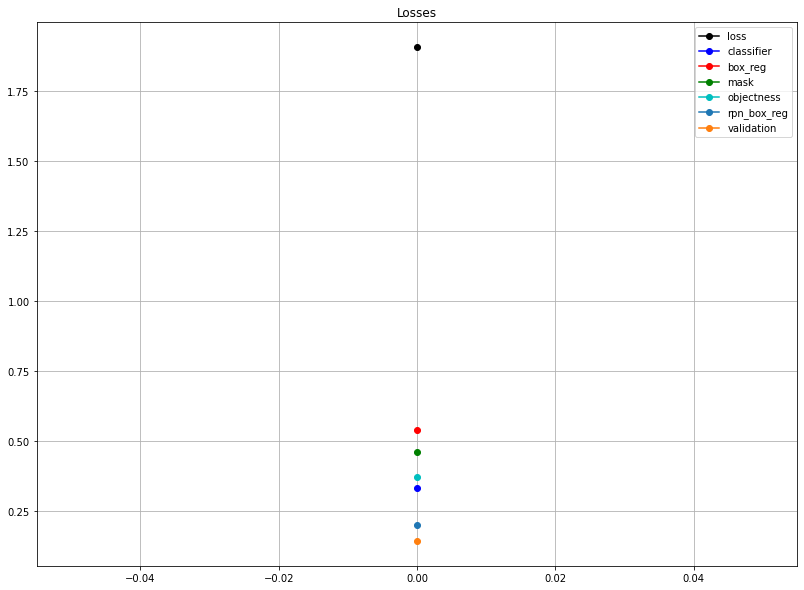

In [8]:
def plot_losses_over_epochs(logger_full, logger_sum):
    loss_classifier, loss_box_reg, loss_mask, loss_objectness, loss_rpn_box_reg =  [], [], [], [], []
    n_epochs = len(logger_full)

    # calculate losses for each epoch
    for list in logger_full:
        loss_classifier_v, loss_box_reg_v, loss_mask_v, loss_objectness_v, loss_rpn_box_reg_v =  0, 0, 0, 0, 0
        for dict in list:
            for key in dict.keys():
                if key == "loss_classifier":
                    loss_classifier_v += dict[key].item()
                if key == "loss_box_reg":
                    loss_box_reg_v += dict[key].item()
                if key == "loss_mask":
                    loss_mask_v += dict[key].item()
                if key == "loss_objectness":
                    loss_objectness_v += dict[key].item()
                if key == "loss_rpn_box_reg":
                    loss_rpn_box_reg_v += dict[key].item()

        loss_classifier.append(loss_classifier_v / len(list))
        loss_box_reg.append(loss_box_reg_v / len(list))
        loss_mask.append(loss_mask_v / len(list))
        loss_objectness.append(loss_objectness_v / len(list))
        loss_rpn_box_reg.append(loss_rpn_box_reg_v / len(list))

    losses = []
    for list in logger_sum:
        losses.append((sum(list)/len(list)))

    val_loss = []
    val_loss = [value.cpu() for value in val_losses] 

    # plot losses
    fig = plt.figure(figsize=(30, 10))
    ax0 = fig.add_subplot(121, title="Losses")

    ax0.plot(range(n_epochs), losses, 'ko-', label='loss')
    ax0.plot(range(n_epochs), loss_classifier, 'bo-', label='classifier')
    ax0.plot(range(n_epochs), loss_box_reg, 'ro-', label='box_reg')
    ax0.plot(range(n_epochs), loss_mask, 'go-', label='mask')
    ax0.plot(range(n_epochs), loss_objectness, 'co-', label='objectness')
    ax0.plot(range(n_epochs), loss_rpn_box_reg, 'o-', label='rpn_box_reg')
    ax0.plot(range(n_epochs), val_loss, 'o-', label='validation')

    plt.grid(True)
    plt.legend(loc="upper right")

plot_losses_over_epochs(logger_full, logger_sum)

# Evaluation of Training

In [9]:
idx = 42
key_image = int(dataset_test[idx][1]["image_id"])
key_anno = int(dataset_test[idx][1]["anno_idx"]) - 1

print("Parcel: ", key_image)

Parcel:  139


In [10]:
image_path = "/home/emj6571/dataset_aehren/images/DOP_AD22_HZ_D10_RGB_18mm_UTM32__multi_band____parcel_" + str(key_image) + "_buff_0__geotiff.tif"
img = Image.open(image_path).convert("RGB")
img = get_transform_torch_img(get_transform_imgaug_img(img))

In [11]:
annotations_path = "/home/emj6571/dataset_aehren/annotations.json"

# get annotations for comparison
def get_annotations(annotations_path, key_anno):
    with nostdout():
        anno, class_name, mask = extract_coco_annotations(annotations_path, key_anno)
        boxes, classes, area, segmentations = [], [], [], []
    for dict in anno:
        segmentations.append(dict["segmentation"])
        boxes.append(dict["bbox"])
        area.append(dict["area"])
        classes.append(class_name)
    anno_wheat_heads = len(boxes)
    return anno_wheat_heads, boxes, mask
anno_wheat_heads, boxes, mask = get_annotations(annotations_path, key_anno)

In [12]:
model_path_full = model_path + "/model_5_epochs_2022-12-14_v2.pt"
model = torch.load(model_path_full)

# predict with selected model
def prediction(model, img):
    img = img.cuda() / 255
    prediction = model([img])

    prediction[0]["boxes"] = torch.Tensor(prediction[0]["boxes"].cpu().detach().numpy())
    prediction[0]["scores"] = torch.Tensor(prediction[0]["scores"].cpu().detach().numpy())
    prediction[0]["labels"] = torch.Tensor(prediction[0]["labels"].cpu().detach().numpy())
    prediction[0]["masks"] = torch.Tensor(prediction[0]["masks"].cpu().detach().numpy())

    return prediction[0]
pred = prediction(model, img)

Parcel: 139
Annotation: 42


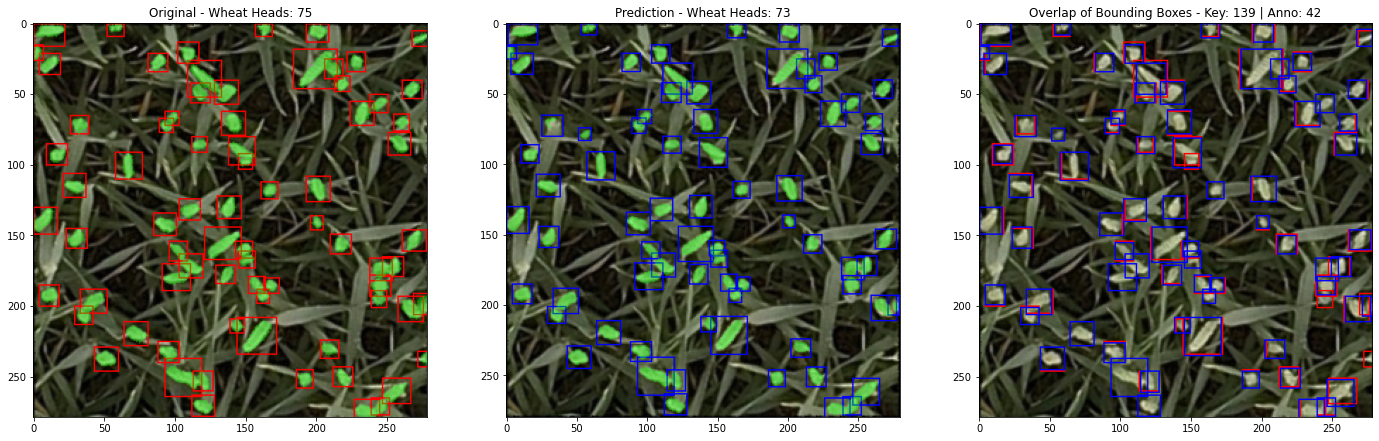

Detected wheat heads before threshold: 85
Detected wheat heads after threshold: 73
Annotated wheat heads: 75
Deviation: -0.02667%


In [13]:
score_threshold = 0.7
mask_threshold = 0.5

# plot original and test set image
def plot_predicted_validation(target, img, score_threshold, mask_threshold, key_image, key_anno, anno_wheat_heads):

    n_detections = target["labels"][target["scores"] > score_threshold]
    boxes_threshold = target["boxes"][target["scores"] > score_threshold]
    masks_threshold = (target["masks"][target["scores"] > score_threshold].squeeze(1)).sum(dim=0) > mask_threshold

    boxes_original = draw_bounding_boxes(torch.as_tensor((dataset_test[key_anno][0] * 255), dtype=torch.uint8), dataset_test[key_anno][1]["boxes"], colors=(255,0,0))
    masks_original = draw_segmentation_masks(boxes_original, dataset_test[key_anno][1]["masks"].sum(dim=0) > mask_threshold, colors=(0,255,0), alpha=0.4).permute(1,2,0)

    boxes_predict = draw_bounding_boxes(img, boxes_threshold, colors=(0,0,255))
    masks_predict = draw_segmentation_masks(boxes_predict, masks_threshold, colors=(0,255,0), alpha=0.4).permute(1,2,0)

    images_overlapped = draw_bounding_boxes(boxes_original, boxes_threshold, colors=(0,0,255)).permute(1,2,0)

    print("Parcel:", key_image)
    print("Annotation:", key_anno)

    f = plt.figure(figsize=(24,14))
    f.add_subplot(1,3,1)
    plt.title("Original - Wheat Heads: " + str(len(dataset_test[key_anno][1]["boxes"])))
    plt.imshow(masks_original)
    f.add_subplot(1,3,2)
    plt.title("Prediction - Wheat Heads: " + str(len(boxes_threshold)))
    plt.imshow(masks_predict)
    f.add_subplot(1,3,3)
    plt.title(f"Overlap of Bounding Boxes - Key: {key_image} | Anno: {key_anno}")
    plt.imshow(images_overlapped)
    plt.show(block=True)

    print("Detected wheat heads before threshold:", len(target["labels"]))
    print("Detected wheat heads after threshold:", len(n_detections))
    print("Annotated wheat heads:", anno_wheat_heads)
    print("Deviation: " + str(np.round((len(n_detections)/anno_wheat_heads)-1, 5)) + "%")

plot_predicted_validation(pred, img, score_threshold, mask_threshold, key_image, key_anno, anno_wheat_heads)

# Create table for stats on test data

In [14]:
# plot original and test set image
def plot_predicted_testimg(target, img, score_threshold, mask_threshold, key_image, key_anno, anno_wheat_heads):

    img = img.type(torch.uint8)

    n_detections = target["labels"][target["scores"] > score_threshold]
    boxes_threshold = target["boxes"][target["scores"] > score_threshold]
    masks_threshold = (target["masks"][target["scores"] > score_threshold].squeeze(1)).sum(dim=0) > mask_threshold

    boxes_original = draw_bounding_boxes(torch.as_tensor((dataset_test[key_anno][0] * 255), dtype=torch.uint8), dataset_test[key_anno][1]["boxes"], colors=(255,0,0))
    masks_original = draw_segmentation_masks(boxes_original, dataset_test[key_anno][1]["masks"].sum(dim=0) > mask_threshold, colors=(0,255,0), alpha=0.4).permute(1,2,0)

    boxes_predict = draw_bounding_boxes(img, boxes_threshold, colors=(0,0,255))
    masks_predict = draw_segmentation_masks(boxes_predict, masks_threshold, colors=(0,255,0), alpha=0.4).permute(1,2,0)

    images_overlapped = draw_bounding_boxes(boxes_original, boxes_threshold, colors=(0,0,255)).permute(1,2,0)

    print("Parcel:", key_image)
    print("Annotation:", key_anno)
    print("Detected wheat heads before threshold:", len(target["labels"]))
    print("Detected wheat heads after threshold:", len(n_detections))
    print("Annotated wheat heads:", anno_wheat_heads)
    print("Deviation: " + str(np.round((len(n_detections)/anno_wheat_heads)-1, 5)) + "%")

    f = plt.figure(figsize=(24,14))
    f.add_subplot(1,3,1)
    plt.title("Original - Wheat Heads: " + str(len(dataset_test[key_anno][1]["boxes"])))
    plt.imshow(masks_original)
    f.add_subplot(1,3,2)
    plt.title("Prediction - Wheat Heads: " + str(len(boxes_threshold)))
    plt.imshow(masks_predict)
    f.add_subplot(1,3,3)
    plt.title(f"Overlap of Bounding Boxes - Key: {key_image} | Anno: {key_anno}")
    plt.imshow(images_overlapped)
    plt.show(block=True)

Parcel: 462
Annotation: 401
Detected wheat heads before threshold: 99
Detected wheat heads after threshold: 85
Annotated wheat heads: 94
Deviation: -0.09574%


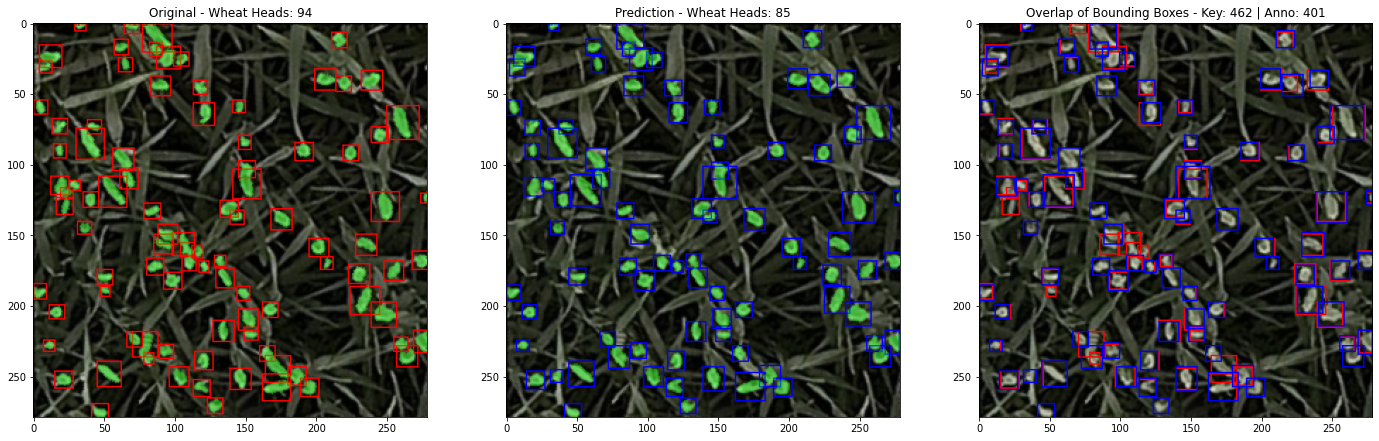

Parcel: 221
Annotation: 134
Detected wheat heads before threshold: 104
Detected wheat heads after threshold: 83
Annotated wheat heads: 65
Deviation: 0.27692%


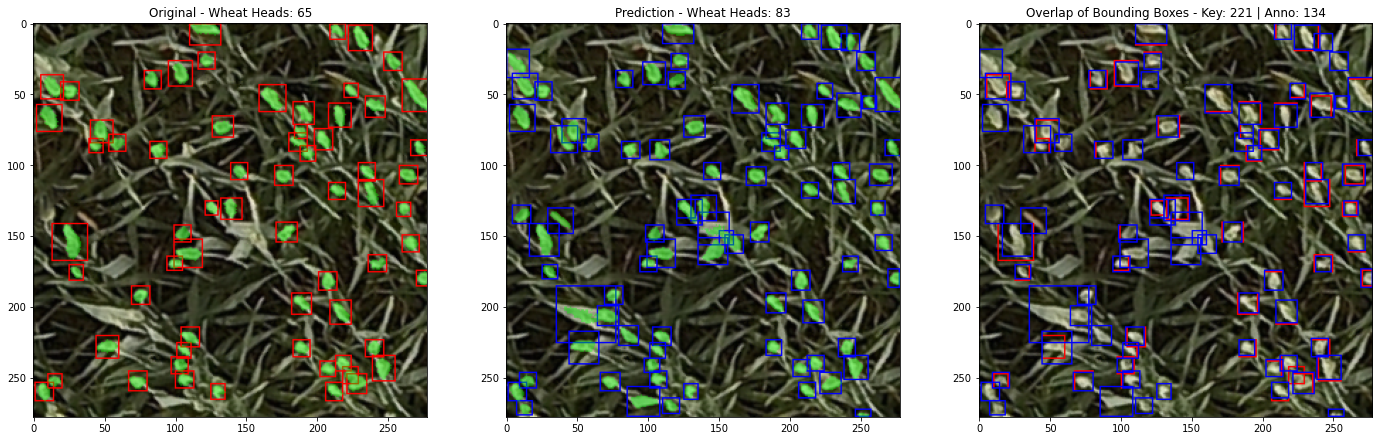

Parcel: 61
Annotation: 473
Detected wheat heads before threshold: 90
Detected wheat heads after threshold: 81
Annotated wheat heads: 81
Deviation: 0.0%


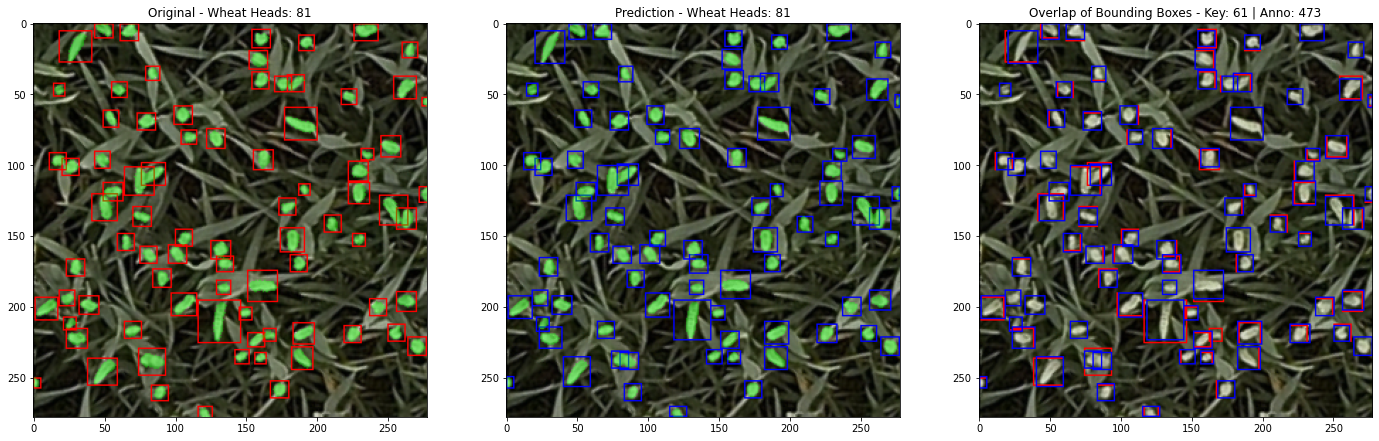

In [15]:
# creates dictionary of test results
def dict_for_testresults():
    image_ids, count_annotations, count_predictions, instance_difference, percentual_difference = [], [], [], [], []

    for idx in range(len(dataset_testing)):
        dict = dataset_testing[idx]
        img = dict[0] * 255

        key_image = int(dict[1]["image_id"])
        key_anno = int(dict[1]["anno_idx"]) - 1

        pred = prediction(model, img)
        anno_wheat_heads, boxes, segmentations = get_annotations(annotations_path, key_anno)

        n_detections = pred["labels"][pred["scores"] > score_threshold]

        image_ids.append(int(key_image))
        count_annotations.append(int(anno_wheat_heads))
        count_predictions.append(int(len(n_detections)))
        instance_difference.append(int(len(n_detections) - anno_wheat_heads))
        percentual_difference.append(np.round((len(n_detections)/anno_wheat_heads)-1, 5))

        if key_image == 221 or key_image == 61 or key_image == 462:
            plot_predicted_testimg(pred, img, 0.7, 0.5, key_image, key_anno, anno_wheat_heads)


    results = {"Image no" : image_ids,
            "Ground-Truth" : count_annotations, 
            "Predicted" : count_predictions, 
            "Instance difference" : instance_difference,
            "Percentual difference" : percentual_difference}

    return results
results = dict_for_testresults()

In [16]:
# create dataframes for values and stats
def create_dataframes(results):
    total, average, deviation = ["Total:"], ["Average:"], ["Standard deviation:"]
    for key in results:
        if key != "Image no":
            total.append(sum(results[key]))
            average.append(total[-1]/(len(results["Image no"])))
            deviation.append(np.std(results[key]))

    # create dataframe for image values
    df = pd.DataFrame(data=results)
    df = df.sort_values("Image no")
    df["Image no"] = df["Image no"].astype("int")
    df["Ground-Truth"] = df["Ground-Truth"].astype("int")
    df["Predicted"] = df["Predicted"].astype("int")
    df["Instance difference"] = df["Instance difference"].astype("int")

    # create dataframe for stats
    stats = {"Category" : None,
                "Ground-Truth" : None, 
                "Predicted" : None, 
                "Instance difference" : None,
                "Percentual difference" : None}
                
    df_stats = pd.DataFrame(data=stats, index=[0])
    df_stats.loc[len(df_stats)] = total
    df_stats.loc[len(df_stats)] = average
    df_stats.loc[len(df_stats)] = deviation
    df_stats = df_stats.drop(index=0)

    return df, df_stats
df, df_stats = create_dataframes(results)

In [17]:
ground_truth = df["Ground-Truth"]
predicted = df["Predicted"]

In [18]:
df = df.style.hide(axis="index")
df_stats = df_stats.style.hide(axis="index")

In [19]:
df_stats

Category,Ground-Truth,Predicted,Instance difference,Percentual difference
Total:,6200,6338,138,2.131510
Average:,80.519481,82.311688,1.792208,0.027682
Standard deviation:,14.426356,13.781467,5.648440,0.081682


In [20]:
df

Image no,Ground-Truth,Predicted,Instance difference,Percentual difference
25,82,86,4,0.048780
42,73,76,3,0.041100
53,99,103,4,0.040400
58,88,92,4,0.045450
61,81,81,0,0.000000
63,95,93,-2,-0.021050
66,72,76,4,0.055560
68,105,119,14,0.133330
71,80,79,-1,-0.012500
76,104,103,-1,-0.009620


# Scatterplot Ground-Truth and Prediction

In [21]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [22]:
r2 = r2_score(ground_truth, predicted)
rmse = np.sqrt(mean_squared_error(ground_truth, predicted))
print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")

R²: 0.83
RMSE: 5.93


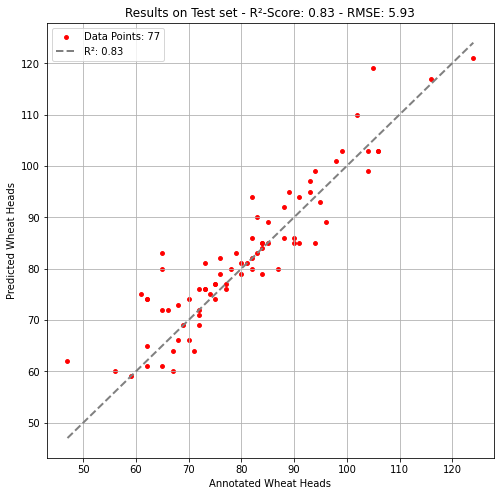

In [24]:
x = np.arange(len(ground_truth))

f = plt.figure(figsize=(8,8))

# Scatter plot of actual vs predicted values
plt.scatter(ground_truth, predicted, color='red', label=f'Data Points: {len(ground_truth)}', s=15)

# Plot the diagonal line representing perfect fit
plt.plot([min(ground_truth), max(ground_truth)], [min(ground_truth), max(ground_truth)], linestyle='--', linewidth=2, color='grey', label=f'R²: {r2:.2f}')

plt.xlabel('Annotated Wheat Heads')
plt.ylabel('Predicted Wheat Heads')
plt.title(f'Results on Test set - R²-Score: {r2:.2f} - RMSE: {rmse:.2f}')
plt.grid(True)
plt.legend()
plt.show(block=True)